In the [Convolutional Neural Network](https://www.kaggle.com/code/aisuko/convolutional-neural-network) notebook, we have learned about convolutional filters that can extract patterns from images. For our MNIST classifier we used 9x5x5 filtersk resulting in 9x24x24 tensor.

We can use the same idea of convolution to extract higher-level patterns in the image. For example, rounded edges of digits such as 8 and 9 can be composed from a number of smaller strokes. To recognize those patterns, we can build another layer of convolution filters on top of the result of the first layer.

In [1]:
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118
Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from torchinfo import summary
import numpy as np

from torchvision.transforms import ToTensor
from torchvision import datasets
from torch.utils.data import DataLoader

In [3]:
# check the paltform, Apple Silicon or Linux
import os, platform

torch_device="cpu"

if 'kaggle' in os.environ.get('KAGGLE_URL_BASE','localhost'):
    torch_device = 'cuda'
else:
    torch_device = 'mps' if platform.system() == 'Darwin' else 'cpu'

In [4]:
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

In [5]:
torch_device

'cuda'

In [6]:
data_train = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

data_test = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_loader = DataLoader(data_train, batch_size=128)
test_loader = DataLoader(data_test, batch_size=128)

100%|██████████| 9912422/9912422 [00:00<00:00, 116917402.03it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 62505517.97it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 48214860.65it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6003948.56it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



## Multi-layer perceptron

In a multi-layer network, we will add one or more `hidden layers`,

<figure><img src="https://hostux.social/system/media_attachments/files/110/733/604/476/365/268/original/3f1163265cf9b88c.png" alt="" ><figcaption><p>Source from Microsoft learning</p></figcaption></figure>

This layer may contain any number of neurons, which will affect how powerful our neural network it, i.e. how many parameters will it have. The more parameters there are in the network, the more data we need to train it.

However, `more` is not always better. A number of parameters of a neural network should be chosen depending on the dataset size, to prevent `overfitting`. 

> Overfitting is a phenomenon when a neural network learns to recognize the training data very well, but fails to generalize to new data. In other words, it memorizes the training data, but does not learn to recognize the patterns in the data.

Our network layer structure will look like this:

<figure><img src="https://hostux.social/system/media_attachments/files/110/733/630/147/169/801/original/21a55f4237dda6ee.png" alt="" ><figcaption><p>Source from Microsoft learning</p></figcaption></figure>

An important thing to note here is the non-linear activation function layer, called `ReLU`. It is important to introduce those non-linear activation functions, because they are one of the reasons neural networks achieve high expressive power. Indeed, it can be demonstrated mathematically that if a network consisted just of a series of linear layers, it would essentially  be equivalent to one linear layer. Thus inserting non-linear functions in beetween layers is important!

Here how two of the most frequently used activation function look:

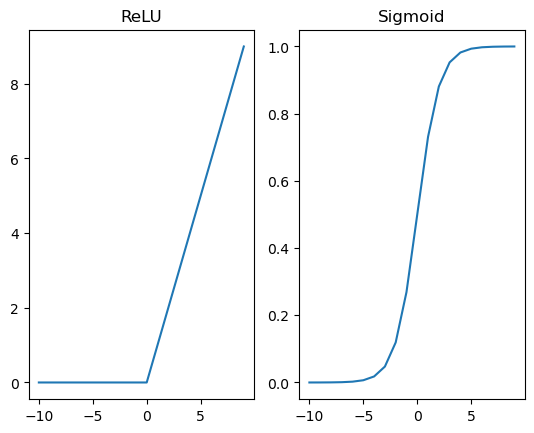

In [7]:
def plot_function(f, name=''):
    plt.plot(range(-10,10), [f(torch.tensor(x, dtype=torch.float32)).item() for x in range(-10,10)]) #f is used to plot the function
    plt.title(name)

# The plt.subplot(121) call is equivalent to plt.subplot(1, 2, 1). It specifies a grid of 1 row and 2 columns, and the subplot is placed in the first position (index 1) of the grid
plt.subplot(121) # 121 means 1 row, 2 columns, 1st subplot
plot_function(torch.relu, 'ReLU')
plt.subplot(122)
plot_function(torch.sigmoid, 'Sigmoid')

Our network can be defined in PyTorch in the following way, using `Sequential` syntax:

In multi-class classification problems, `nn.Softmax(dim=1)` is typically used to normalize the output probabilities for each sample in the batch. On the other hand, `nn.Softmax(dim=0)` can be used to normalize the output probabilities across all samples in the batch, which can be useful in some cases.

In [8]:
net = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 100), # 784 is the input size, 100 is the output size
    nn.ReLU(),             # ReLU is the activation function
    nn.Linear(100, 10),    # 100 is the input size, 10 is the output size
    nn.Softmax(dim=0)
).to(torch_device)

summary(net, input_size=(1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Flatten: 1-1                           [1, 784]                  --
├─Linear: 1-2                            [1, 100]                  78,500
├─ReLU: 1-3                              [1, 100]                  --
├─Linear: 1-4                            [1, 10]                   1,010
├─Softmax: 1-5                           [1, 10]                   --
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
Total mult-adds (M): 0.08
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.32
Estimated Total Size (MB): 0.32

Here we use `torchsummary.summary()` function to display a detailed layer-by-layer structure of a network with some other useful information. In particular, we can see the number of parameters of the network.

Let's train this multi-layerd perceptron:

In [9]:
def train_epoch(net, dataloader, lr=0.01, optimizer=None, loss_fn=nn.NLLLoss()):
    optimizer = optimizer or torch.optim.Adam(net.parameters(), lr=lr) # use Adam optimizer if not provided
    net.train() # put the network into training mode make sure the parameters are trainable
    total_loss,acc,count =0,0,0
    for features, labels in dataloader:
        features,labels = features.to(torch_device), labels.to(torch_device)
        optimizer.zero_grad() # reset the gradients to zero before each batch to avoid accumulation
        out=net(features) # forward pass of the mini-batch through the network to obtain the outputs
        loss=loss_fn(out,labels) # compute the loss
        loss.backward() # compute the gradients of the loss with respect to all the parameters of the network
        optimizer.step() # update the parameters of the network using the gradients to minimize the loss
        total_loss+=loss # accumulate the loss for inspection
        _,preds=torch.max(out,dim=1) # compute the predictions to obtain the accuracy
        acc+=(preds==labels).sum() # accumulate the correct predictions
        count+=len(labels) # accumulate the total number of examples
    return total_loss.item()/count, acc.item()/count # return the loss and accuracy

def validate(net, dataloader, loss_fn=nn.NLLLoss()):
    net.eval() # put the network into evaluation mode to deactivate the dropout layers
    count,acc,loss =0,0,0
    with torch.no_grad(): # deactivate autograd to save memory and speed up computations
        for features, labels in dataloader:
            features,labels = features.to(torch_device), labels.to(torch_device)
            out=net(features) # forward pass of the mini-batch through the network to obtain the outputs
            loss += loss_fn(out,labels) # compute the loss
            preds=torch.max(out,dim=1)[1] # compute the predictions to obtain the accuracy
            acc+=(preds==labels).sum() # accumulate the correct predictions
            count+=len(labels) # accumulate the total number of examples
    return loss.item()/count, acc.item()/count # return the loss and accuracy

def train(net, train_loader, test_loader, optimizer=None, lr=0.01, epochs=10, loss_fn=nn.NLLLoss()):
    optimizer = optimizer or torch.optim.Adam(net.parameters(), lr=lr) # use Adam optimizer if not provided
    res = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc':[]}
    for ep in range(epochs):
        tl, ta = train_epoch(net, train_loader, optimizer=optimizer,lr=lr, loss_fn=loss_fn)
        vl,va = validate(net, test_loader, loss_fn=loss_fn)
        print(f"Epoch {ep:2}, Train acc={ta:.3f}, Val acc={va:.3f}, Train loss={tl:.3f}, Val loss={vl:.3f}")
        res['train_loss'].append(tl)
        res['train_acc'].append(ta)
        res['val_loss'].append(vl)
        res['val_acc'].append(va)
    return res

def plot_results(hist):
    plt.figure(figsize=(15,5)) # figure is used to create a new figure
    plt.subplot(121) # subplot is used to create a new subplot on a grid
    plt.plot(hist['train_acc'], label='Training acc')
    plt.plot(hist['val_acc'], label='Validation acc')
    plt.legend() # legend is used to add a legend to the plot
    plt.subplot(122) # plot the loss
    plt.plot(hist['train_loss'], label='Training loss')
    plt.plot(hist['val_loss'], label='Validation loss')
    plt.legend()

hist = train(net, train_loader, test_loader, epochs=5)

Epoch  0, Train acc=0.654, Val acc=0.668, Train loss=-0.001, Val loss=-0.001
Epoch  1, Train acc=0.631, Val acc=0.603, Train loss=-0.001, Val loss=-0.001
Epoch  2, Train acc=0.618, Val acc=0.651, Train loss=-0.001, Val loss=-0.001
Epoch  3, Train acc=0.591, Val acc=0.589, Train loss=-0.001, Val loss=-0.001
Epoch  4, Train acc=0.560, Val acc=0.539, Train loss=-0.001, Val loss=-0.001


Please note the following:

* This network is more expressive than the one layered perceptron we have trained in the previous notebook. Thus it achieves a much higher training accuracy and given sufficiently large number of parameters - it can get to almost 100%

* Onece the validation accuracy stops increasing - it means that the model has reached it's ability to generalize, and further training will likely to result in overfitting

## Class-based network definitions

Defining models using a `Sequential` style as a list of layers seems very convenient but it is somewhat limited. At some point you may need to define more complex networks, which contain shared weights, or some non-linera connections between layers.

In [10]:
from torch.nn.functional import relu, log_softmax

class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.flatten = nn.Flatten()
        self.hidden = nn.Linear(28*28, 100)
        self.out = nn.Linear(100, 10)
    
    def forward(self, x):
        x =self.flatten(x)
        x = self.hidden(x)
        x = relu(x)
        x = self.out(x)
        x = log_softmax(x, dim=0)
        return x

net = MyNet().to(torch_device)

summary(net, input_size=(1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
MyNet                                    [1, 10]                   --
├─Flatten: 1-1                           [1, 784]                  --
├─Linear: 1-2                            [1, 100]                  78,500
├─Linear: 1-3                            [1, 10]                   1,010
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
Total mult-adds (M): 0.08
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.32
Estimated Total Size (MB): 0.32

You can see that the structure of a neural network is the same as the `Sequential` defined network, but the definition is more explicit. Our custom neural network is represented by a class inherited from `torch.nn.Module` class.

Class definition consists of two  parts:
* In the constructor `__init__` we define all layers that our network will have. Those layers are stored as internal variables of the class, and PyTorch will automatically know that parameters of those layers shoudl be optimized when training. Internally, PyTorch uses `parameters()` method to look for all trainable parameters, and `nn.Module` will automatically collect all trainable parameters from all sub-modules.
* We define the `forward` method that does the forward pass computation of out neural network. In our case, we start with a parameter tensor `x`, and explicitly pass it thorugh all the layers and activation functions, starting from `flatten`, up to the final layer `out`. When we apply our neural network to some input data `x` by writing `out = net(x)`, the `forward` methos is called.

In fact, `Sequential` networks are represented in a very similar manner, they just store a list of layers and apply them sequentially during the forward pass. Here we have a chance to represent this process more ecplicity, which evetually gives us more flexibility. That is one of the reasons that using classes for neural network definition is a recommended and preferred practice.

Now we will train our network and make sure we get similar results as before:

Epoch  0, Train acc=0.932, Val acc=0.956, Train loss=0.023, Val loss=0.022
Epoch  1, Train acc=0.960, Val acc=0.959, Train loss=0.022, Val loss=0.022
Epoch  2, Train acc=0.966, Val acc=0.964, Train loss=0.021, Val loss=0.022
Epoch  3, Train acc=0.970, Val acc=0.964, Train loss=0.021, Val loss=0.022
Epoch  4, Train acc=0.972, Val acc=0.965, Train loss=0.021, Val loss=0.022


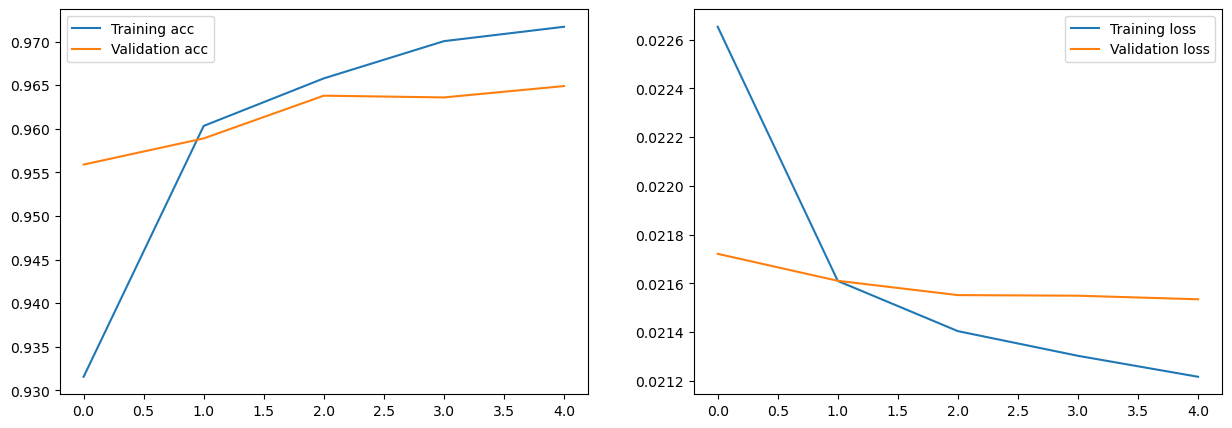

In [11]:
hist = train(net, train_loader, test_loader, epochs=5)
plot_results(hist)

Multi-level networks can achieve higher accuracy than single-layer perceptron, however, they are not perfect for computer vision tasks. In images, there are some structural patterns that can help us classify an obejct regardless of it's position in the image, but perceptrons do not allow us to extract those patterns and look for them selectively.